# ロボットマニピュレータの逆運動学を4×4マトリクスを用いて解く！！！

Created by Hiroki Miyamoto 

Modified by Masahiro Furukawa, Aug 18, 2020

8/18現在，下記DHパラメータ表は更新されていないため参照不可．リンクパラメータもDHパラメータに準拠していない(古川)．

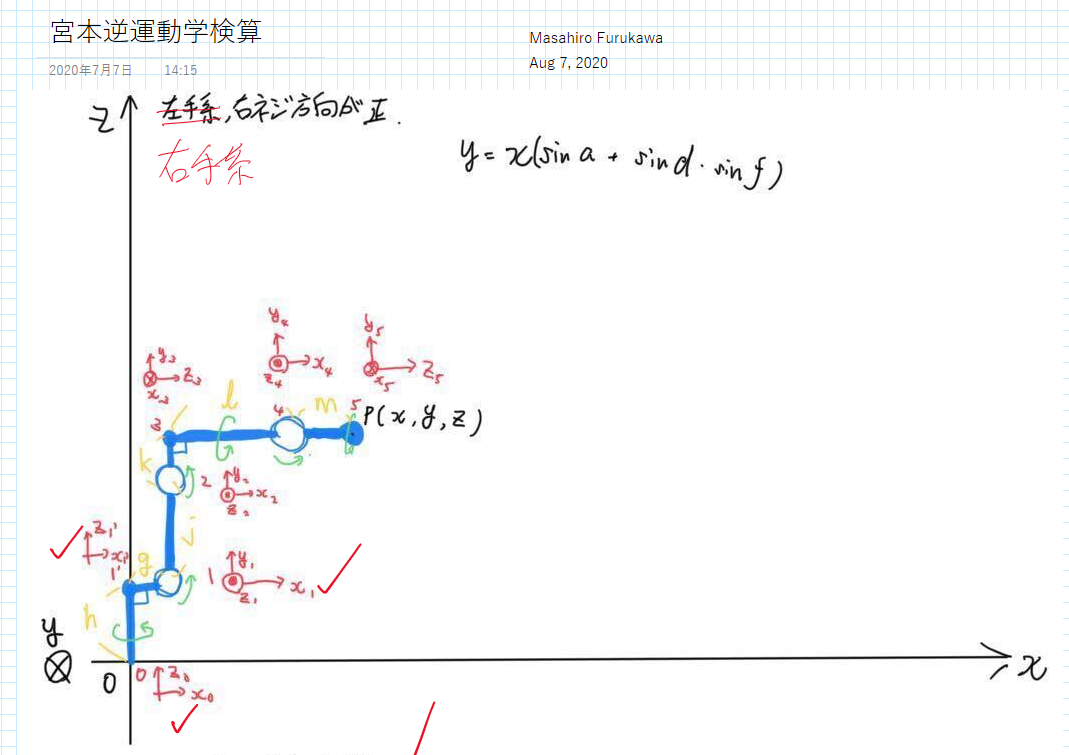

In [53]:
#参考URL -> https://qiita.com/tibigame/items/61cecf86fc978628bfee
#参考図書 -> ポールのロボット・マニピュレータ

import numpy as np
import sympy as sym
sym.init_printing()
Pi = sym.S.Pi # 円周率
E = sym.S.Exp1 # 自然対数の底
I = sym.S.ImaginaryUnit # 虚数単位

#sympyの円周率の方を使うことをすすめる（こっちの方が量子化誤差が大きくなる．numpyも同様に大きい）
import math
pi = math.pi

# 使用する変数の定義(小文字1文字は全てシンボルとする)
(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z) = sym.symbols('a b c d e f g h i j k l m n o p q r s t u v w x y z')
#a～fは角度変数

(n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z) = sym.symbols('n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z')


In [23]:
#sin.cosの簡易記述用
def S(a):
    return sym.sin(a)

def C(a):
    return sym.cos(a)

In [24]:
#回転・並進行列
def rotx(a):
    return sym.Matrix([[1, 0, 0, 0], [0, C(a), -S(a), 0], [0, S(a), C(a), 0], [0, 0, 0, 1]])

def roty(a):
    return sym.Matrix([[C(a), 0, S(a), 0], [0, 1, 0, 0], [-S(a), 0, C(a), 0], [0, 0, 0, 1]])

def rotz(a):
    return sym.Matrix([[C(a), -S(a), 0, 0], [S(a), C(a), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def trans(x, y, z):
    return sym.Matrix([[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]])


### DH法に基づく座標系間の関係表現

|座標系 i|Z_i-1軸回りに角度θ_i|Z_i-1に沿って距離d_iだけ並進|回転後のX_i-1 (=X_i)に沿って長さa_iだけ並進|X_i軸周りにねじれ角α_iだけ回転|
|-|-|-|-|-|
|1|a|h|g|Pi/2|
|2|b|0|0|0|(yにj)
|3|c|0|-k|-Pi/2|(cの初期位置は-Pi/2)
|4|d|l|0|Pi/2|
|5|e|0|0|-Pi/2|(yにm)
|6|f|n|0|0|

座標系0→1：
Z0軸方向にd1だけ平行移動してから、関節１の関節角度θ1だけ回転、a1=0、α1=0

座標系1→2：
X1軸方向にa2移動、関節２の角度θ2だけ回転、α2=0、d2=0

座標系2→3：
X2軸方向にa3移動、X2軸回りにα3=180度(π)回転、回転後のZ2軸方向(鉛直下向)にd3移動、θ3=0

座標系3→4：
Z0軸方向にd1だけ平行移動してから、関節１の関節角度θ1だけ回転、a1=0、α1=0

座標系4→5：
X1軸方向にa2移動、関節２の角度θ2だけ回転、α2=0、d2=0

座標系5→6：
X2軸方向にa3移動、X2軸回りにα3=180度(π)回転、回転後のZ2軸方向(鉛直下向)にd3移動、θ3=0

### 変換行列 A1 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

In [25]:
A1=rotz(a)*trans(g,0,h)*rotx(Pi/2)
sym.trigsimp(A1)

⎡cos(a)  0  sin(a)   g⋅cos(a)⎤
⎢                            ⎥
⎢sin(a)  0  -cos(a)  g⋅sin(a)⎥
⎢                            ⎥
⎢  0     1     0        h    ⎥
⎢                            ⎥
⎣  0     0     0        1    ⎦

In [26]:
# 逆行列  A1inv
A1inv=rotx(-Pi/2)*trans(-g,0,-h)*rotz(-a)
sym.trigsimp(A1inv)

⎡cos(a)  sin(a)   0  -g⎤
⎢                      ⎥
⎢  0        0     1  -h⎥
⎢                      ⎥
⎢sin(a)  -cos(a)  0  0 ⎥
⎢                      ⎥
⎣  0        0     0  1 ⎦

In [27]:
# 逆行列をかけると単位行列になることの確認
ret = A1inv*A1
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

### 変換行列 A2 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）


In [28]:
A2=rotz(b)*trans(0,j,0)
sym.trigsimp(A2)

⎡cos(b)  -sin(b)  0  -j⋅sin(b)⎤
⎢                             ⎥
⎢sin(b)  cos(b)   0  j⋅cos(b) ⎥
⎢                             ⎥
⎢  0        0     1      0    ⎥
⎢                             ⎥
⎣  0        0     0      1    ⎦

In [29]:
# 逆行列  A2inv
A2inv=trans(0,-j,0)*rotz(-b)
sym.trigsimp(A2inv)

⎡cos(b)   sin(b)  0  0 ⎤
⎢                      ⎥
⎢-sin(b)  cos(b)  0  -j⎥
⎢                      ⎥
⎢   0       0     1  0 ⎥
⎢                      ⎥
⎣   0       0     0  1 ⎦

In [30]:
# 逆行列をかけると単位行列になることの確認
ret = A2inv*A2
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

### 変換行列 A3 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）



In [31]:
A3=rotz(c)*trans(0,k,0)*roty(Pi/2)
sym.trigsimp(A3)

⎡0   -sin(c)  cos(c)  -k⋅sin(c)⎤
⎢                              ⎥
⎢0   cos(c)   sin(c)  k⋅cos(c) ⎥
⎢                              ⎥
⎢-1     0       0         0    ⎥
⎢                              ⎥
⎣0      0       0         1    ⎦

In [32]:
# 逆行列  A3inv
A3inv=roty(-Pi/2)*trans(0,-k,0)*rotz(-c)
sym.trigsimp(A3inv)

⎡   0       0     -1  0 ⎤
⎢                       ⎥
⎢-sin(c)  cos(c)  0   -k⎥
⎢                       ⎥
⎢cos(c)   sin(c)  0   0 ⎥
⎢                       ⎥
⎣   0       0     0   1 ⎦

In [33]:
# 逆行列をかけると単位行列になることの確認
ret = A3inv*A3
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

### 変換行列 A4 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

In [34]:
A4=rotz(d)*trans(0,0,l)*roty(-Pi/2)
sym.trigsimp(A4)

⎡0  -sin(d)  -cos(d)  0⎤
⎢                      ⎥
⎢0  cos(d)   -sin(d)  0⎥
⎢                      ⎥
⎢1     0        0     l⎥
⎢                      ⎥
⎣0     0        0     1⎦

In [35]:
# 逆行列  A4inv
A4inv=roty(Pi/2)*trans(0,0,-l)*rotz(-d)
sym.trigsimp(A4inv)

⎡   0        0     1  -l⎤
⎢                       ⎥
⎢-sin(d)  cos(d)   0  0 ⎥
⎢                       ⎥
⎢-cos(d)  -sin(d)  0  0 ⎥
⎢                       ⎥
⎣   0        0     0  1 ⎦

In [36]:
# 逆行列をかけると単位行列になることの確認
ret = A4inv*A4
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

### 変換行列 A5 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

In [37]:
A5=rotz(e)*trans(m,0,0)*roty(Pi/2)
sym.trigsimp(A5)

⎡0   -sin(e)  cos(e)  m⋅cos(e)⎤
⎢                             ⎥
⎢0   cos(e)   sin(e)  m⋅sin(e)⎥
⎢                             ⎥
⎢-1     0       0        0    ⎥
⎢                             ⎥
⎣0      0       0        1    ⎦

In [38]:
# 逆行列  A5inv
A5inv=roty(-Pi/2)*trans(-m,0,0)*rotz(-e)
sym.trigsimp(A5inv)

⎡   0       0     -1  0 ⎤
⎢                       ⎥
⎢-sin(e)  cos(e)  0   0 ⎥
⎢                       ⎥
⎢cos(e)   sin(e)  0   -m⎥
⎢                       ⎥
⎣   0       0     0   1 ⎦

In [39]:
# 逆行列をかけると単位行列になることの確認
ret = A5inv*A5
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

### 変換行列 A6 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

In [40]:
A6=rotz(f)*trans(0,0,n)
sym.trigsimp(A6)

⎡cos(f)  -sin(f)  0  0⎤
⎢                     ⎥
⎢sin(f)  cos(f)   0  0⎥
⎢                     ⎥
⎢  0        0     1  n⎥
⎢                     ⎥
⎣  0        0     0  1⎦

In [41]:
# 逆行列  A6inv
A6inv=trans(0,0,-n)*rotz(-f)
sym.trigsimp(A6inv)

⎡cos(f)   sin(f)  0  0 ⎤
⎢                      ⎥
⎢-sin(f)  cos(f)  0  0 ⎥
⎢                      ⎥
⎢   0       0     1  -n⎥
⎢                      ⎥
⎣   0       0     0  1 ⎦

In [42]:
# 逆行列をかけると単位行列になることの確認
ret = A6inv*A6
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

# 逆運動学

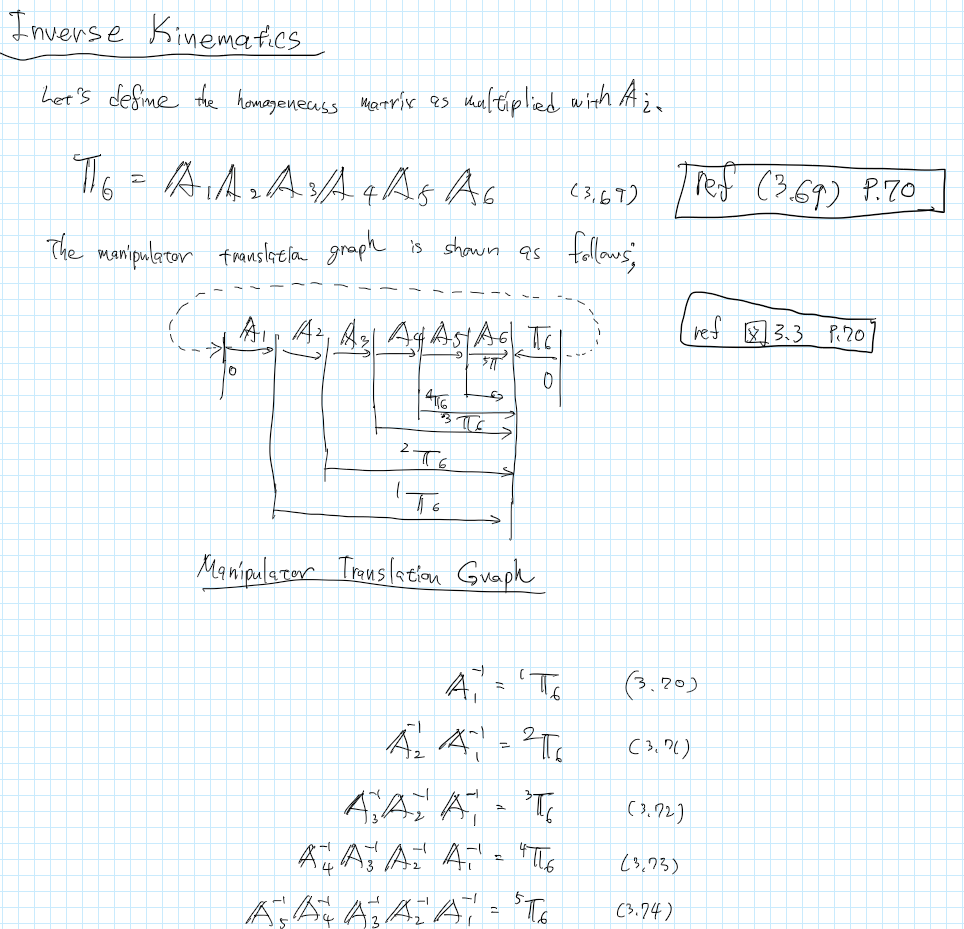

In [58]:
T5 = A6
T4 = A5*A6
T3 = A4*A5*A6
T2 = A3*A4*A5*A6
T1 = A2*A3*A4*A5*A6
T  = A1*A2*A3*A4*A5*A6

T16 =                        A1inv  #  eq(3.70)
T26 =                  A2inv*A1inv  #  eq(3.71)
T36 =            A3inv*A2inv*A1inv  #  eq(3.72)
T46 =      A4inv*A3inv*A2inv*A1inv  #  eq(3.73)
T56 =A5inv*A4inv*A3inv*A2inv*A1inv  #  eq(3.74)

#x,y,zの順運動学が確認したければここを表示して，Tの４列目を確認
#sym.trigsimp(T*trans(n,0,0))

In [59]:
sym.trigsimp(T)

⎡ ((sin(a)⋅sin(d) - sin(b + c)⋅cos(a)⋅cos(d))⋅cos(e) - sin(e)⋅cos(a)⋅cos(b + c
⎢                                                                             
⎢(-(sin(a)⋅sin(b + c)⋅cos(d) + sin(d)⋅cos(a))⋅cos(e) - sin(a)⋅sin(e)⋅cos(b + c
⎢                                                                             
⎢                             (-sin(e)⋅sin(b + c) + cos(d)⋅cos(e)⋅cos(b + c))⋅
⎢                                                                             
⎣                                                                     0       

))⋅sin(f) - (sin(a)⋅cos(d) + sin(d)⋅sin(b + c)⋅cos(a))⋅cos(f)    ((sin(a)⋅sin(
                                                                              
))⋅sin(f) + (-sin(a)⋅sin(d)⋅sin(b + c) + cos(a)⋅cos(d))⋅cos(f)  (-(sin(a)⋅sin(
                                                                              
sin(f) + sin(d)⋅cos(f)⋅cos(b + c)                                             
                                                   

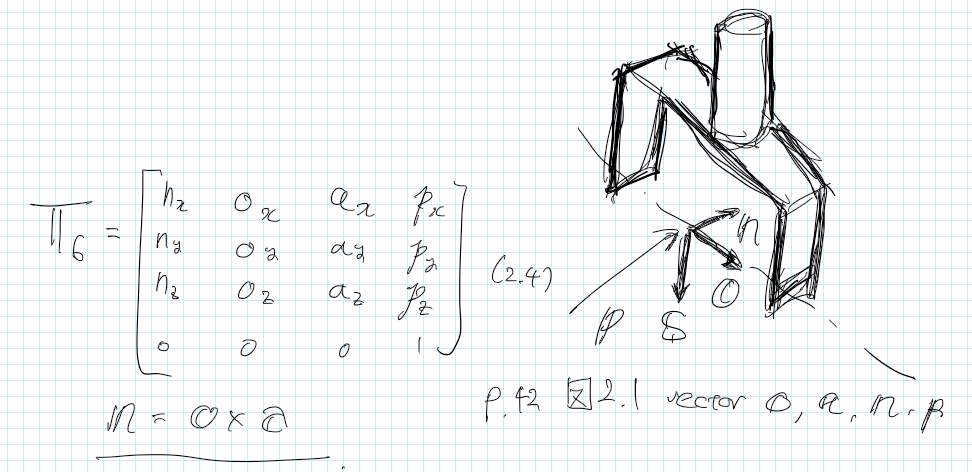

In [62]:
T6=sym.Matrix([[n_x, o_x, a_x, p_x], [n_y, o_y, a_y, p_y], [n_z, o_z, a_z, p_z], [0, 0, 0, 1]])
T6

⎡nₓ   oₓ   aₓ   pₓ ⎤
⎢                  ⎥
⎢n_y  o_y  a_y  p_y⎥
⎢                  ⎥
⎢n_z  o_z  a_z  p_z⎥
⎢                  ⎥
⎣ 0    0    0    1 ⎦

### 順運動学計算用Cソースコードを得る

In [63]:
# Masahiro Furukawa
# Aug, 17, 2020
#
# refernce : https://qiita.com/JmpM/items/4bea4997aaf406cca3b4

# 三角関数をまとめる
T=sym.trigsimp(T)

# Cソースを得る
for ii in range(4):
    for jj in range(4):
        idx = jj*4+ii
        code = sym.ccode(T[idx],assign_to=('Trans['+str(jj)+']['+str(ii)+']'), standard='C89')
        print(code)
    print()

Trans[0][0] = ((sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*cos(e) - sin(e)*cos(a)*cos(b + c))*sin(f) - (sin(a)*cos(d) + sin(d)*sin(b + c)*cos(a))*cos(f);
Trans[1][0] = (-(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*cos(e) - sin(a)*sin(e)*cos(b + c))*sin(f) + (-sin(a)*sin(d)*sin(b + c) + cos(a)*cos(d))*cos(f);
Trans[2][0] = (-sin(e)*sin(b + c) + cos(d)*cos(e)*cos(b + c))*sin(f) + sin(d)*cos(f)*cos(b + c);
Trans[3][0] = 0;

Trans[0][1] = ((sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*cos(e) - sin(e)*cos(a)*cos(b + c))*cos(f) + (sin(a)*cos(d) + sin(d)*sin(b + c)*cos(a))*sin(f);
Trans[1][1] = (-(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*cos(e) - sin(a)*sin(e)*cos(b + c))*cos(f) - (-sin(a)*sin(d)*sin(b + c) + cos(a)*cos(d))*sin(f);
Trans[2][1] = (-sin(e)*sin(b + c) + cos(d)*cos(e)*cos(b + c))*cos(f) - sin(d)*sin(f)*cos(b + c);
Trans[3][1] = 0;

Trans[0][2] = (sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*sin(e) + cos(a)*cos(e)*cos(b + c);
Trans[1][2] = -(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*sin(

# inverse kinematics

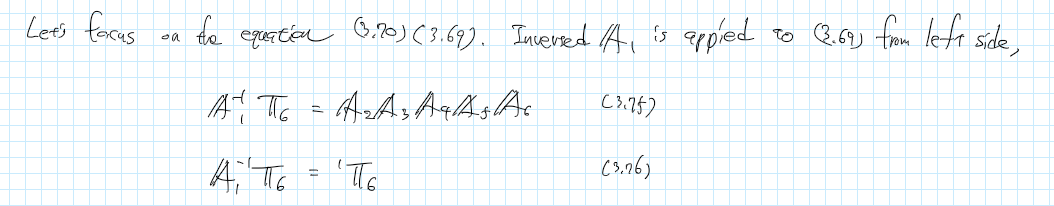

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_2 
    \boldsymbol{A}_3 
    \boldsymbol{A}_4 
    \boldsymbol{A}_5 
    \boldsymbol{A}_6 　　　(3.75)\\
    {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{1}\boldsymbol{T}_6   　　　(3.76)
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$

In [72]:
# Left hand 
sym.trigsimp( A1inv * T6 )

⎡nₓ⋅cos(a) + n_y⋅sin(a)  oₓ⋅cos(a) + o_y⋅sin(a)  aₓ⋅cos(a) + a_y⋅sin(a)  -g + 
⎢                                                                             
⎢         n_z                     o_z                     a_z                 
⎢                                                                             
⎢nₓ⋅sin(a) - n_y⋅cos(a)  oₓ⋅sin(a) - o_y⋅cos(a)  aₓ⋅sin(a) - a_y⋅cos(a)    pₓ⋅
⎢                                                                             
⎣          0                       0                       0                  

pₓ⋅cos(a) + p_y⋅sin(a)⎤
                      ⎥
    -h + p_z          ⎥
                      ⎥
sin(a) - p_y⋅cos(a)   ⎥
                      ⎥
        1             ⎦

In [73]:
# Right hand of (3.75)
sym.trigsimp( T1 )

⎡-(sin(e)⋅cos(b + c) + sin(b + c)⋅cos(d)⋅cos(e))⋅sin(f) - sin(d)⋅sin(b + c)⋅co
⎢                                                                             
⎢(-sin(e)⋅sin(b + c) + cos(d)⋅cos(e)⋅cos(b + c))⋅sin(f) + sin(d)⋅cos(f)⋅cos(b 
⎢                                                                             
⎢                      sin(d)⋅sin(f)⋅cos(e) - cos(d)⋅cos(f)                   
⎢                                                                             
⎣                                        0                                    

s(f)  -(sin(e)⋅cos(b + c) + sin(b + c)⋅cos(d)⋅cos(e))⋅cos(f) + sin(d)⋅sin(f)⋅s
                                                                              
+ c)  (-sin(e)⋅sin(b + c) + cos(d)⋅cos(e)⋅cos(b + c))⋅cos(f) - sin(d)⋅sin(f)⋅c
                                                                              
                            sin(d)⋅cos(e)⋅cos(f) + sin(f)⋅cos(d)              
                                                   

In [74]:
# Right hand of (3.76)
sym.trigsimp( T16 )

⎡cos(a)  sin(a)   0  -g⎤
⎢                      ⎥
⎢  0        0     1  -h⎥
⎢                      ⎥
⎢sin(a)  -cos(a)  0  0 ⎥
⎢                      ⎥
⎣  0        0     0  1 ⎦